In [1]:
#import pytorch and setting up device agnostic code
import torch
from torch import nn

device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Making a custom dataset from Food101

 getting images for only 3 classes-pizza,steak and sushi and store them in their respective files

In [ ]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

#setup data directory
import pathlib
data_dir=pathlib.Path("../data")

get thr original food101 datset

In [ ]:
train_data=datasets.Food101(root=data_dir,
                            split="train",
                            download=True)

test_data=datasets.Food101(root=data_dir,
                           split="test",
                           download=True)

100%|██████████| 5.00G/5.00G [03:06<00:00, 26.8MB/s]


In Daniel Bourke’s notebook, the dataset is downloaded using data_dir = pathlib.Path("../data"), which points one level above Colab’s working directory (/content/).

 This is why the downloaded food-101 folder does not appear in Colab’s file explorer — because the explorer only shows folders inside /content/.

 Daniel did this intentionally to follow best practices seen in real-world machine learning projects, where large datasets are kept separate from the main codebase to keep the workspace clean and organized.

 Storing data in ../data/ helps mimic a proper project structure, prevents clutter in the notebook directory, and encourages modular workflows. Although it hides the folder from view, it doesn’t impact accessibility via code — everything still works as expected

In [ ]:
train_data

Dataset Food101
    Number of datapoints: 75750
    Root location: ../data
    split=train

In [ ]:
class_names=train_data.classes
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In print(class_names[train_data[0][1]]), the first [0] gets the first sample from the dataset, which is a tuple of (image, label). The second [1] accesses the label (an integer) from that tuple. Since class_names is a list of class labels like ['pizza', 'steak', 'sushi'], using that integer helps get the actual class name. So this line prints the class name of the first image in the dataset.

churros


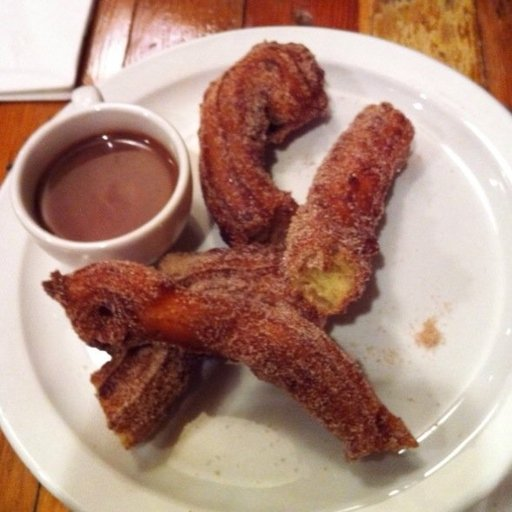

In [ ]:
print(class_names[train_data[0][1]])
train_data[0][0]   #1st train data tuple 1st index that is image

find subset of appropriate classes

In [ ]:
# Get random 10% of training images
import random

# Setup data paths
data_path = data_dir / "food-101" / "images"
target_classes = ["pizza", "steak", "sushi"]

# Change amount of data to get (e.g. 0.1 = random 10%, 0.2 = random 20%)
amount_to_get = 0.2

# Create function to separate a random amount of data
def get_subset(image_path=data_path,
               data_splits=["train", "test"],
               target_classes=["pizza", "steak", "sushi"],
               amount=0.1,
               seed=42):
    random.seed(42)
    label_splits = {}

    # Get labels
    for data_split in data_splits:
        print(f"[INFO] Creating image split for: {data_split}...")
        label_path = data_dir / "food-101" / "meta" / f"{data_split}.txt"
        with open(label_path, "r") as f:
            labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes]

        # Get random subset of target classes image ID's
        number_to_sample = round(amount * len(labels))
        print(f"[INFO] Getting random subset of {number_to_sample} images for {data_split}...")
        sampled_images = random.sample(labels, k=number_to_sample)

        # Apply full paths
        image_paths = [pathlib.Path(str(image_path / sample_image) + ".jpg") for sample_image in sampled_images]
        label_splits[data_split] = image_paths
    return label_splits

label_splits = get_subset(amount=amount_to_get)
label_splits["train"][:10]

[INFO] Creating image split for: train...
[INFO] Getting random subset of 450 images for train...
[INFO] Creating image split for: test...
[INFO] Getting random subset of 150 images for test...


[PosixPath('../data/food-101/images/pizza/3269634.jpg'),
 PosixPath('../data/food-101/images/pizza/1524655.jpg'),
 PosixPath('../data/food-101/images/steak/2825100.jpg'),
 PosixPath('../data/food-101/images/steak/225990.jpg'),
 PosixPath('../data/food-101/images/steak/1839481.jpg'),
 PosixPath('../data/food-101/images/pizza/38349.jpg'),
 PosixPath('../data/food-101/images/pizza/3018077.jpg'),
 PosixPath('../data/food-101/images/sushi/93139.jpg'),
 PosixPath('../data/food-101/images/pizza/2702825.jpg'),
 PosixPath('../data/food-101/images/sushi/200025.jpg')]

Move training and testing images to dedicated folders

In [ ]:
# Create target directory path
target_dir_name = f"../data/pizza_steak_sushi_{str(int(amount_to_get*100))}_percent"
print(f"Creating directory: '{target_dir_name}'")

# Setup the directories
target_dir = pathlib.Path(target_dir_name)

# Make the directories
target_dir.mkdir(parents=True, exist_ok=True)

Creating directory: '../data/pizza_steak_sushi_20_percent'


In [ ]:

import shutil

for image_split in label_splits.keys():
    for image_path in label_splits[str(image_split)]:
        dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
        if not dest_dir.parent.is_dir():
            dest_dir.parent.mkdir(parents=True, exist_ok=True)
        print(f"[INFO] Copying {image_path} to {dest_dir}...")
        shutil.copy2(image_path, dest_dir)

[INFO] Copying ../data/food-101/images/pizza/3269634.jpg to ../data/pizza_steak_sushi_20_percent/train/pizza/3269634.jpg...
[INFO] Copying ../data/food-101/images/pizza/1524655.jpg to ../data/pizza_steak_sushi_20_percent/train/pizza/1524655.jpg...
[INFO] Copying ../data/food-101/images/steak/2825100.jpg to ../data/pizza_steak_sushi_20_percent/train/steak/2825100.jpg...
[INFO] Copying ../data/food-101/images/steak/225990.jpg to ../data/pizza_steak_sushi_20_percent/train/steak/225990.jpg...
[INFO] Copying ../data/food-101/images/steak/1839481.jpg to ../data/pizza_steak_sushi_20_percent/train/steak/1839481.jpg...
[INFO] Copying ../data/food-101/images/pizza/38349.jpg to ../data/pizza_steak_sushi_20_percent/train/pizza/38349.jpg...
[INFO] Copying ../data/food-101/images/pizza/3018077.jpg to ../data/pizza_steak_sushi_20_percent/train/pizza/3018077.jpg...
[INFO] Copying ../data/food-101/images/sushi/93139.jpg to ../data/pizza_steak_sushi_20_percent/train/sushi/93139.jpg...
[INFO] Copying ../

Zip up images folder to be more easily transported


In [ ]:
# Zip pizza_steak_sushi images
zip_file_name = data_dir / f"pizza_steak_sushi_{str(int(amount_to_get*100))}_percent"
shutil.make_archive(zip_file_name,
                    format="zip",
                    root_dir=target_dir)

'/data/pizza_steak_sushi_20_percent.zip'

In [ ]:
!ls -la ../data/

total 4909956
drwxr-xr-x 4 root root       4096 Jul  9 11:41 .
drwxr-xr-x 1 root root       4096 Jul  9 11:36 ..
drwxr-xr-x 4 3156  320       4096 Jul  9  2014 food-101
-rw-r--r-- 1 root root 4996278331 Jul  9 11:39 food-101.tar.gz
drwxr-xr-x 4 root root       4096 Jul  9 11:41 pizza_steak_sushi_20_percent
-rw-r--r-- 1 root root   31491084 Jul  9 11:41 pizza_steak_sushi_20_percent.zip


In [ ]:
!mkdir -p pizza_steak_sushi
!unzip ../data/pizza_steak_sushi_20_percent.zip -d pizza_steak_sushi

Archive:  ../data/pizza_steak_sushi_20_percent.zip
   creating: pizza_steak_sushi/test/
   creating: pizza_steak_sushi/train/
   creating: pizza_steak_sushi/train/pizza/
   creating: pizza_steak_sushi/train/steak/
   creating: pizza_steak_sushi/train/sushi/
  inflating: pizza_steak_sushi/train/pizza/1947572.jpg  
  inflating: pizza_steak_sushi/train/pizza/979998.jpg  
  inflating: pizza_steak_sushi/train/pizza/3860002.jpg  
  inflating: pizza_steak_sushi/train/pizza/1544197.jpg  
  inflating: pizza_steak_sushi/train/pizza/1899785.jpg  
  inflating: pizza_steak_sushi/train/pizza/3109486.jpg  
  inflating: pizza_steak_sushi/train/pizza/1535273.jpg  
  inflating: pizza_steak_sushi/train/pizza/3281494.jpg  
  inflating: pizza_steak_sushi/train/pizza/1649276.jpg  
  inflating: pizza_steak_sushi/train/pizza/218142.jpg  
  inflating: pizza_steak_sushi/train/pizza/393658.jpg  
  inflating: pizza_steak_sushi/train/pizza/3464027.jpg  
  inflating: pizza_steak_sushi/train/pizza/3478964.jpg  
  in

In [ ]:
!ls ../data

food-101	 pizza_steak_sushi_20_percent
food-101.tar.gz  pizza_steak_sushi_20_percent.zip


In [ ]:
#walk_through_dir("pizza_steak_sushi")
#Need helper function

-------------------------------------------------------------------------

**GET DATA**

our dataset is a subset of Food101 dataset.

food101 starts at 101 different classes of food and 1000 images per classes(750 for training and 250 for testing)

our dataset starts with 3 classes of food and only 10% of the image(75 training and 25 testing)

why do this?

when starting out ML projects,it is important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment

In [1]:
import requests
import zipfile
from pathlib import Path

#setup path to a data folder
data_path=Path("data/")
image_path=data_path/"pizza_steak_sushi"

#if the image folder does not exist , download it

if image_path.is_dir():
  print(f"{image_path} directory exists already...")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True,exist_ok=True)

#download pizza,steak and sushi data

with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("downaloading pizza,steak and sushi zipped data...")
  f.write(request.content)

#unzip pizza,steak,sushi data

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
    print("unzipping pizza,steak and sushi data...")
    zip_ref.extractall(image_path)    #unzipping all the zip_ref data into the image_path


Did not find data/pizza_steak_sushi directory, creating one...
downaloading pizza,steak and sushi zipped data...
unzipping pizza,steak and sushi data...


data preparation and data exploration

In [2]:
import os
def walk_through_dir(dir_path):
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}' ")


In [3]:
walk_through_dir(image_path)

there are 2 directories and 0 images in 'data/pizza_steak_sushi' 
there are 3 directories and 0 images in 'data/pizza_steak_sushi/test' 
there are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi' 
there are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza' 
there are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak' 
there are 3 directories and 0 images in 'data/pizza_steak_sushi/train' 
there are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi' 
there are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza' 
there are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak' 


setup train and testing paths

In [4]:
train_dir=image_path/"train"
test_dir=image_path/"test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

visualizing images

1.get all of the image path

2.pick a random image path using python's random.choice()

3.get the image class name using Pathlib.path.parent.stem

4.let's open image with python PIL

5.show the image and print metadata


In [5]:
image_path

PosixPath('data/pizza_steak_sushi')

random image path:data/pizza_steak_sushi/test/pizza/2871261.jpg
image class:pizza
image height:384
image width:512


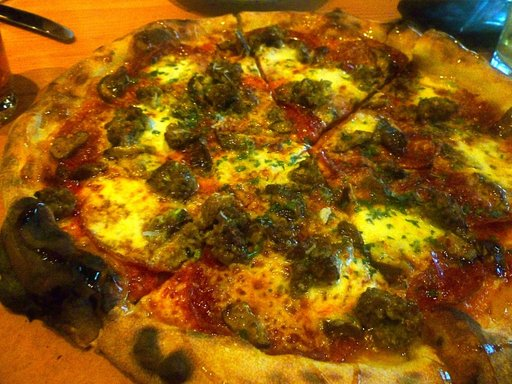

In [6]:
import random
from PIL import Image

#random.seed(42)

#get all image path
image_path_list=list(image_path.glob("*/*/*.jpg"))  #now this going to stick together all the images of a certain combination/pattern given

#pick a random image path
random_image_path=random.choice(image_path_list)
random_image_path

#get image class from the path name (the image class is the name of directory  where the image is stored)
image_class=random_image_path.parent.stem


#opein image
img=Image.open(random_image_path)

#print metadata
print(f"random image path:{random_image_path}")
print(f"image class:{image_class}")
print(f"image height:{img.height}")
print(f"image width:{img.width}")
img


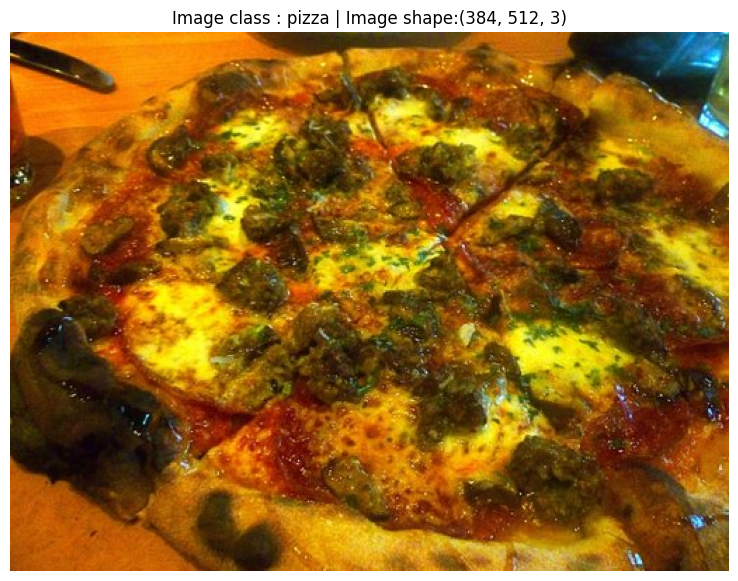

In [7]:
#try to visualize image using matplotlib
import numpy as np
import matplotlib.pyplot as plt

#turn image into an array
img_as_array=np.asarray(img)

#plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class : {image_class} | Image shape:{img_as_array.shape}")
plt.axis(False)
plt.show()

Transforming data

tensors -> dataset  ->  dataloaders

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transforming data with torchvision.transforms

Image flipping is an important technique used in data augmentation to make models more robust and generalized. When we flip an image horizontally, it helps the model understand that an object remains the same even if it appears from the left or the right. This teaches the model concepts like symmetry and invariance.

Flipping also helps reduce overfitting because the model sees slightly different versions of the same image, encouraging it to learn general features rather than memorizing patterns.

Additionally, flipping effectively increases the diversity of the dataset, which is especially useful when working with small datasets.

It's important to note that transforms like RandomHorizontalFlip do not add extra flipped images — instead, each image has a 50% chance of being flipped during training, meaning no new images are created, only the original ones are randomly modified in real time.

In [9]:
#write a transform for image
data_transform= transforms.Compose ([
    #resize our images to 64x64
    transforms.Resize(size=(64,64)),
    #flip the image randomly (data augmentation)
    transforms.RandomHorizontalFlip(p=0.5),
    #turn the images to a tensor
    transforms.ToTensor() #convert a PIL image or numpy ndarray to tensor in range [0,1]
])

In [10]:
img_transformed=data_transform(img)
print(img_transformed.shape)
print(img_transformed.dtype)

torch.Size([3, 64, 64])
torch.float32


This function selects random image from a path of images and loads/trnaforms them and then plots original vs transformed version.

In [11]:
#visulazing transformed images
#n is no of images to be transformed at aa time
def plot_transformed_images(image_paths : list ,transform,n=3,seed=None):
    if seed:
      random.seed(seed)
    random_image_paths= random.sample(image_paths,k=n)

    for image_path in random_image_paths:
      with Image.open(image_path) as f:
        fig,ax=plt.subplots(nrows=1,ncols=2)
        ax[0].imshow(f)
        ax[0].set_title(f"original \nsize:{f.size}")
        ax[0].axis("off")

        #transform image and plot target image
        transformed_image=transform(f).permute(1,2,0) # we need to change shape for matplotlib,matpltlib accept colour channel last
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"transformed \nshape:{transformed_image.shape}")
        ax[1].axis("off")

        fig.suptitle(f"Class:{image_path.parent.stem}",fontsize=16)  # to get the class name





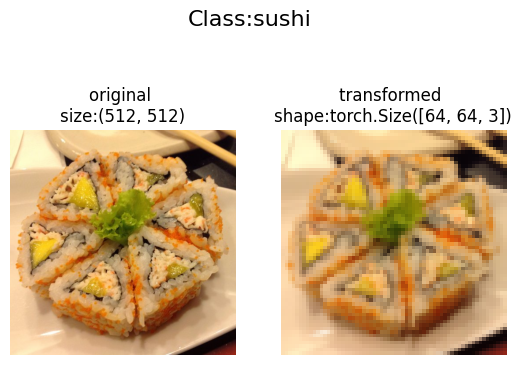

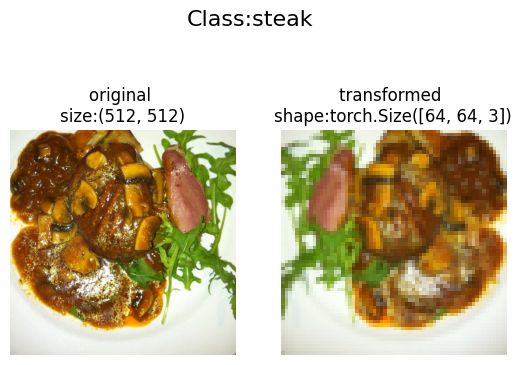

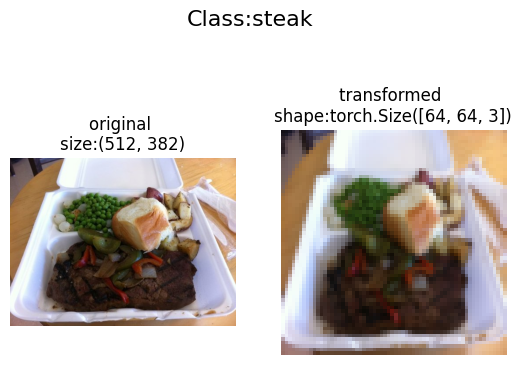

In [12]:
plot_transformed_images(image_paths =image_path_list,
                        transform=data_transform,
                        n=3,
                        )

option 1: loading image data using Imagefolder

we can load image classification data using torchvision.datasets.ImageFolder

In [13]:
from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transform,
                                target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
#get class names as list
class_names=train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
#get class names as dict
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
#length of the dataset
len(train_data),len(test_data)

(225, 75)

visualizing a loaded image from train data

In [17]:
#index on the train_data dataset to get single image and label
img,label=train_data[0][0],train_data[0][1]
print(f"imgage tensor: {img}")
print(f"image shape:{img.shape}")
print(f"image dataype:{img.dtype}")
print(f"image label:{label}")
print(class_names[label])
print(f"label datatype:{type(label)}")

imgage tensor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

In [18]:
#Rearrange the order of dimensions for matplotlib
img_permute=img.permute(1,2,0)
print(img.shape ) #original shape
print(img_permute.shape ) #changed shape

torch.Size([3, 64, 64])
torch.Size([64, 64, 3])


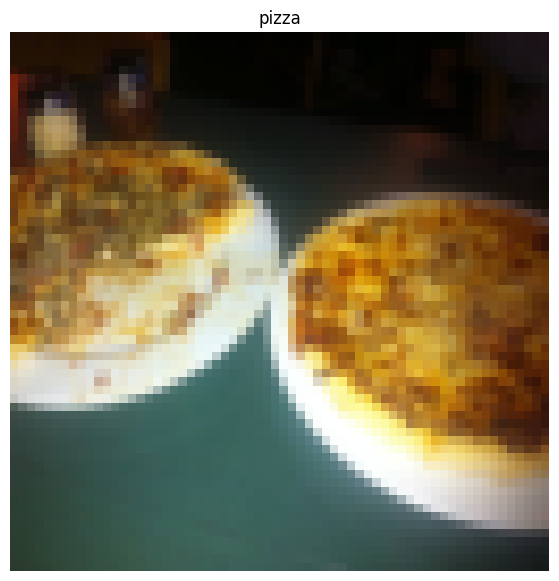

In [19]:
#plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label])
plt.show()

In [20]:
import os
os.cpu_count()

2

In [21]:
#turningloaded image datasets into pytorch DataLoaders

from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader=DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True)

test_dataloader=DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ea84ef5a910>,
 <torch.utils.data.dataloader.DataLoader at 0x7ea84ef637d0>)

In [22]:
len(train_dataloader),len(test_dataloader)

(225, 75)

In [23]:
img,label=next(iter(train_dataloader))
#batch size is 1
print(f"image shape:{img.shape}")
print(f"label shape:{label.shape}")

image shape:torch.Size([1, 3, 64, 64])
label shape:torch.Size([1])


option 2 :creating a custom data loading class in pytorch

1.want to be able to load images from file

2.want to able to get class names from the dataset

3.want to to be able to get classes as dictionary

pros:

1.can create a "dataset" out of almost everything

2.not limited a to pytorch pre-built dataset functions

cons:

1.not all "dataset" will work eventhough we can create it.

2.performance or error issues due to more code

In [24]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

In [25]:
#instance of torchvision.datasets.ImageFolder()
train_data.classes,train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

creating a helper function to get class names

1.get the class names using os.scandir()to traverse a target directory (ideally the directory is in standard image classification format)

2.raise an error if class name are not found

3.turn class names into dict and a list and return them

In [26]:
target_directory=train_dir
print(f"target dir:{target_directory}")

#get the class name from the target directory
class_names_found=sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

target dir:data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [27]:
#finds the class folder names in a target dictionary
def find_classes(directory:str) ->Tuple[list[str], Dict[str,int]]:
    #get the class names by scanning the traget directory
    classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    #raise an error if class names could not be found
    if not classes:
      raise FileNotFoundError(f"couldn't find any classes in {directory} .... please check file structure")

    #create a dictionary of index labels
    class_to_idx={class_name: i for i,class_name in enumerate(classes)}
    return classes,class_to_idx


In [28]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

create a custom dataset to replicate ImageFolder

1.subclass torch.utils.data.Dataset

2.init aur subclass with a taregt drectory and transform.

3.create several attributes
   
  paths-paths of our image

  tranform-the transform we would like to use

  classes- a list of target classes

  class_to_idx- a dict of target classes mapped to integer variable

4.create a function load_images(), this function will open an image

5.overwrite the _len()_ to return length of dataset

6.overwrite the __getitem()__ method to return a given sample when passed an index


In [29]:
from torch.utils.data import Dataset
#subclassing
class ImageFolderCustom(Dataset):
  #intialize our custom dataset
  def __init__(self,targ_dir:str,transform=None):

    #create several class attributes
    #get all image paths
    self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))

    #setup transforms
    self.transform=transform

    #create clases and class_to_idx attributes
    self.classes,self.class_to_idx=find_classes(targ_dir)

  #create function to load images
  def load_image(self,index:int) ->Image.Image:
      image_path=self.paths[index]
      return Image.open(image_path)

  #overwrite len
  def __len__(self) -> int:
    return len(self.paths)

  #overwrite __getitem__() mehtod
  def __getitem__(self,index:int)->Tuple[torch.Tensor,int]:
    img=self.load_image(index)
    class_name=self.paths[index].parent.name    #this expects path in format:data_folder/class_name/image.jpg
    class_idx=self.class_to_idx[class_name]

  #tranform if necessary
    if self.transform:
      return self.transform(img),class_idx
    else:
      return img,class_idx


In [30]:
#create a transform
from torchvision import transforms
train_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [31]:
train_data_custom=ImageFolderCustom(targ_dir=train_dir,
                                    transform=train_transforms)

test_data_custom=ImageFolderCustom(targ_dir=test_dir,
                                   transform=test_transforms)

In [32]:
train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x7ea84ed8fed0>,
 <__main__.ImageFolderCustom at 0x7ea84f04b610>)

In [33]:
len(train_data),len(train_data_custom)

(225, 225)

In [34]:
len(test_data),len(test_data_custom)

(75, 75)

In [35]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [36]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [37]:
#check for equality
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


writing a helper function to visualize random images from our custom daatsets

1.take in a dataset and other parameters such as class names and how many images to visulaize

2.to prevent the display getting out of hand, let's cap the no of images to see at 10

3.set the random seed for reproducibility

4.get a list of random sample indexes from the target dataset

5.setup a matplotlib plot

6.loop through the random sample images and plot them with matplotlib

In [38]:
def display_random_images(dataset,
                          classes:List[str]=None,
                          n: int=10,
                          display_shape: bool =True,
                          seed:int= None):

      #adjust display if n is too high
      if n>10:
        n=10
        display_shape=False
        print(f"for display purposes, n should not be larger than 10, setting it to 10 and removing shape display")

      if seed:
        random.seed(seed)

      #get random sample index
      random_samples_idx=random.sample(range(len(dataset)),k=n)

      #setup plot
      plt.figure(figsize=(16,8))


      #loop through random indexes and plot them
      for i,targ_sample in enumerate(random_samples_idx):
        targ_image,targ_label=dataset[targ_sample][0], dataset[targ_sample][1]

        # adjust tensor dimension for plotting
        targ_image_adjust=targ_image.permute(1,2,0)

        #plot adjusted samples
        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
          title=f"class: {classes[targ_label]}"
        if display_shape:
          title=title+f" | shape: {targ_image_adjust.shape}"
        plt.title(title)

plt.show()

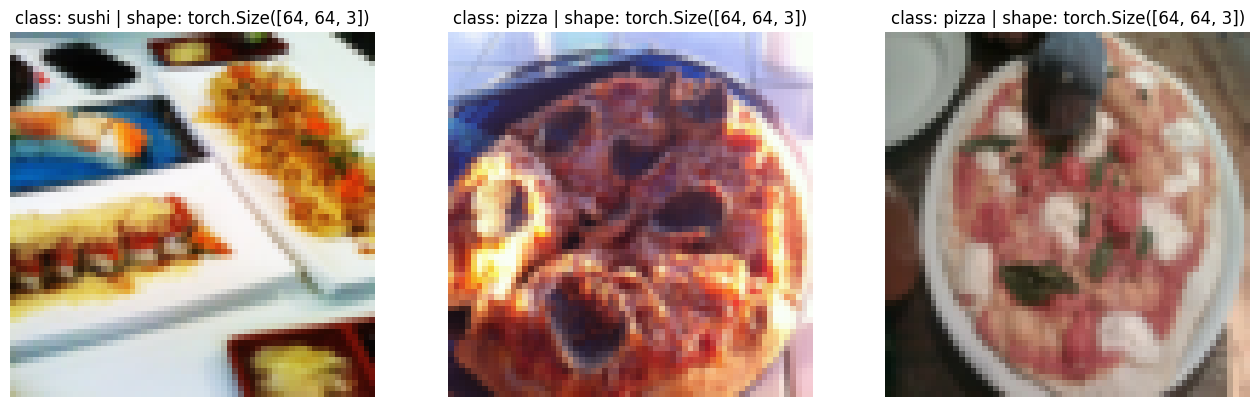

In [39]:
#display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=3,
                      classes=class_names,
                      seed=42)

for display purposes, n should not be larger than 10, setting it to 10 and removing shape display


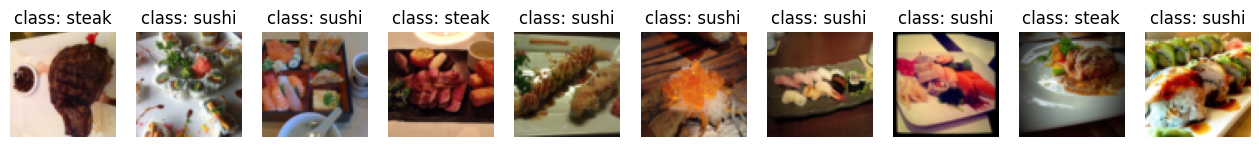

In [40]:
#display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=13,
                      classes=train_data_custom.classes,
                      seed=42)

turn custom loaded images into dataloader

In [41]:
from torch.utils.data import DataLoader
BATCH_SIZE=1
NUM_WORKERS=os.cpu_count()
train_dataloader_custom=DataLoader(dataset=train_data_custom,
                                   batch_size=BATCH_SIZE,
                                   num_workers=NUM_WORKERS,
                                   shuffle=True)

test_dataloader_custom=DataLoader(dataset=test_data_custom,
                                   batch_size=BATCH_SIZE,
                                   num_workers=NUM_WORKERS,
                                   shuffle=False)

train_data_custom,test_dataloader_custom

(<__main__.ImageFolderCustom at 0x7ea84ed8fed0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ea84e514890>)

In [42]:
#get image and label from custom dataloader
img_custom,label_custom=next(iter(train_dataloader_custom))
print(f"image shape:{img_custom.shape}")
print(f"label shape:{label_custom.shape}")

image shape:torch.Size([1, 3, 64, 64])
label shape:torch.Size([1])


data augmentation with torchvision.transforms

data augmentation is process of artificially adding diversity to the training data

this may mean applying various image transformations to the training images

let's take a look at one particular type of data augmnetation used to train pytorch vision models to state of the art levels

this practice makes models more generalizable model to unseen data

**Trivial augment**

In [43]:
from torchvision import transforms

train_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), #intensity
    transforms.ToTensor()

])

test_transform=transforms.Compose([
     transforms.Resize(size=(224,224)),
    transforms.ToTensor()

])

In [44]:
#get all image path
image_path_list=list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/test/sushi/46797.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3806282.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2190404.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/207578.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/858157.jpg')]

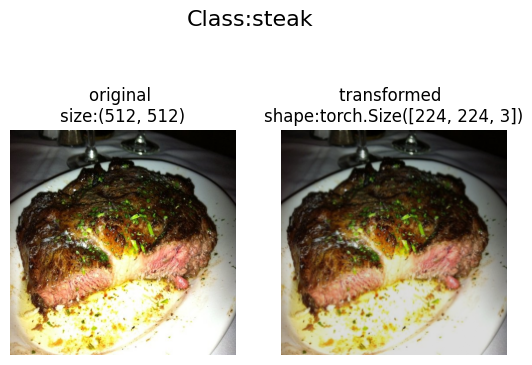

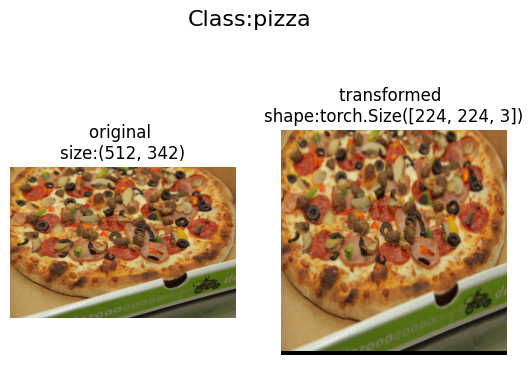

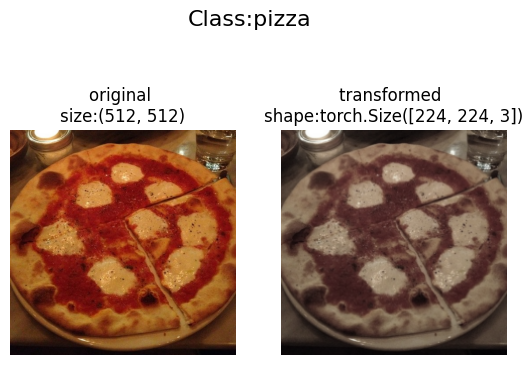

In [45]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

Building a baseline model

Model 0: TinyVGG without data augmentation

creating transfors and loading data for Model 0

In [46]:
#create a simple transform
simple_transform=transforms.Compose([
                                     transforms.Resize(size=(64,64)),
                                     transforms.ToTensor()])

In [47]:
#Load and tranform data
train_data_simple=datasets.ImageFolder(root=train_dir,
                                       transform=simple_transform)

test_data_simple=datasets.ImageFolder(root=test_dir,
                                       transform=simple_transform)

#turn data datasets into Dataloaders
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

train_dataloader_simple=DataLoader(dataset=train_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=True,
                                   num_workers=NUM_WORKERS)

test_dataloader_simple=DataLoader(dataset=test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=NUM_WORKERS)

Building Model

In [48]:
import torch
from torch import nn

In [49]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape:int,
                 hidden_units:int,
                 output_shape:int) -> None:

      super().__init__()
      self.conv_block_1=nn.Sequential (
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                       stride=2)
      )

      self.conv_block_2=nn.Sequential (
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                       stride=2)
      )

      self.classifier=nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features=hidden_units * 13 * 13,
                    out_features=output_shape)
      )

    def forward(self,x):
      x=self.conv_block_1(x)
      #print(x.shape)
      x=self.conv_block_2(x)
      #print(x.shape)
      x=self.classifier(x)
      #print(x.shape)
      return x

In [50]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [51]:
torch.manual_seed(42)
model_0=TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(class_names)) .to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

doing a forward pass on a single image to test our model shapes

In [52]:
#get a single image batch
image_batch,label_batch=next(iter(train_dataloader_simple))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [53]:
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

using torchinfo package to get summary of our model

In [54]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo


from torchinfo import summary
summary(model_0,input_size=([1,3,64,64]))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

Training and testing loop for  model_0

In [55]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):

  model.train()

  #setup train loss and train accuracy values
  train_loss,train_acc=0,0

  #loop through data loader in each data batches
  for batch,(X,y) in enumerate(dataloader):
    X,y=X.to(device),y.to(device)

    #forward pass
    y_pred=model(X)   #output raw logits

    #calculate loss
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #accuracy metric
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  train_loss=train_loss/len(dataloader)  #len(dataloader)= no of batches
  train_acc=train_acc/len(dataloader)
  return train_loss,train_acc





In [56]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn=torch.nn.Module,
              device=device):

  model.eval()
  test_loss,test_acc=0,0

  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X,y=X.to(device),y.to(device)

      test_pred_logits=model(X)
      loss=loss_fn(test_pred_logits,y)

      test_loss+=loss.item()
      test_pred_labels=torch.argmax(torch.softmax(test_pred_logits,dim=1),dim=1)
      test_acc+=(test_pred_labels==y).sum().item()/len(test_pred_labels)

  test_loss=test_loss/len(dataloader)
  test_acc=test_acc/len(dataloader)
  return test_loss,test_acc



train function to train and evaluate our model

In [57]:
from tqdm.auto import tqdm

def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module=nn.CrossEntropyLoss,
          epochs:int=5,
          device=device):

  #create empty result dictionary
  results={"train_loss":[],
            "train_acc":[],
            "test_loss":[],
            "test_acc":[]}

  # loop through training and testing steps for no of epochs

  for epoch in tqdm(range(epochs)):
      train_loss,train_acc=train_step(model=model,
                                      dataloader=train_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      device=device)

      test_loss,test_acc=test_step(model=model,
                                   dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   device=device)

      print(f"Epoch:{epoch+1} | train_loss:{train_loss:.4f} | train_acc:{train_acc:.4f} | test_loss:{test_loss:.4f} | test_acc:{test_acc:.4f}")

      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  return results


In [58]:
torch.manual_seed(42)
NUM_EPOCHS=5
model_0=TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(train_data.classes)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam (params=model_0.parameters(),
                            lr=0.001)

from timeit import default_timer as timer
start_time=timer()
model_0_results=train(model=model_0,
                      train_dataloader=train_dataloader_simple,
                      test_dataloader=test_dataloader_simple,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      epochs=NUM_EPOCHS)
end_time=timer()
print(f"trainig time:{end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:1 | train_loss:1.1063 | train_acc:0.3047 | test_loss:1.0983 | test_acc:0.3011
Epoch:2 | train_loss:1.0998 | train_acc:0.3281 | test_loss:1.0697 | test_acc:0.5417
Epoch:3 | train_loss:1.0869 | train_acc:0.4883 | test_loss:1.0808 | test_acc:0.4924
Epoch:4 | train_loss:1.0843 | train_acc:0.4023 | test_loss:1.0607 | test_acc:0.5833
Epoch:5 | train_loss:1.0663 | train_acc:0.4141 | test_loss:1.0657 | test_acc:0.5644
trainig time:8.928 seconds


In [59]:
model_0_results

{'train_loss': [1.1063196659088135,
  1.0997908860445023,
  1.0868788808584213,
  1.0843187719583511,
  1.066272497177124],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.40234375, 0.4140625],
 'test_loss': [1.0983218749364216,
  1.0697179238001506,
  1.080779790878296,
  1.0607255697250366,
  1.0656605164210002],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

plotting the loss curve of model_0

A **loss curve** is a way of tracking your model's progress every time

In [60]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [61]:
def plot_loss_curves(results:Dict[str,List[float]]):
   #get loss values of result dictionary
   loss=results["train_loss"]
   test_loss=results["test_loss"]

   #get accuracy values of result dictionary
   accuracy=results["train_acc"]
   test_accuracy=results["test_acc"]

   #figure out no of epoch
   epochs=range(len(results["train_loss"]))

   plt.figure(figsize=(15,7))

   #plot loss
   plt.subplot(1,2,1)
   plt.plot(epochs,loss,label="train_loss")
   plt.plot(epochs,test_loss,label="test_loss")
   plt.title("loss")
   plt.xlabel("epochs")
   plt.legend()

   #plot accuracy
   plt.subplot(1,2,2)
   plt.plot(epochs,accuracy,label="train_accuracy")
   plt.plot(epochs,test_accuracy,label="test_accuracy")
   plt.title("accuracy")
   plt.xlabel("epochs")
   plt.legend()


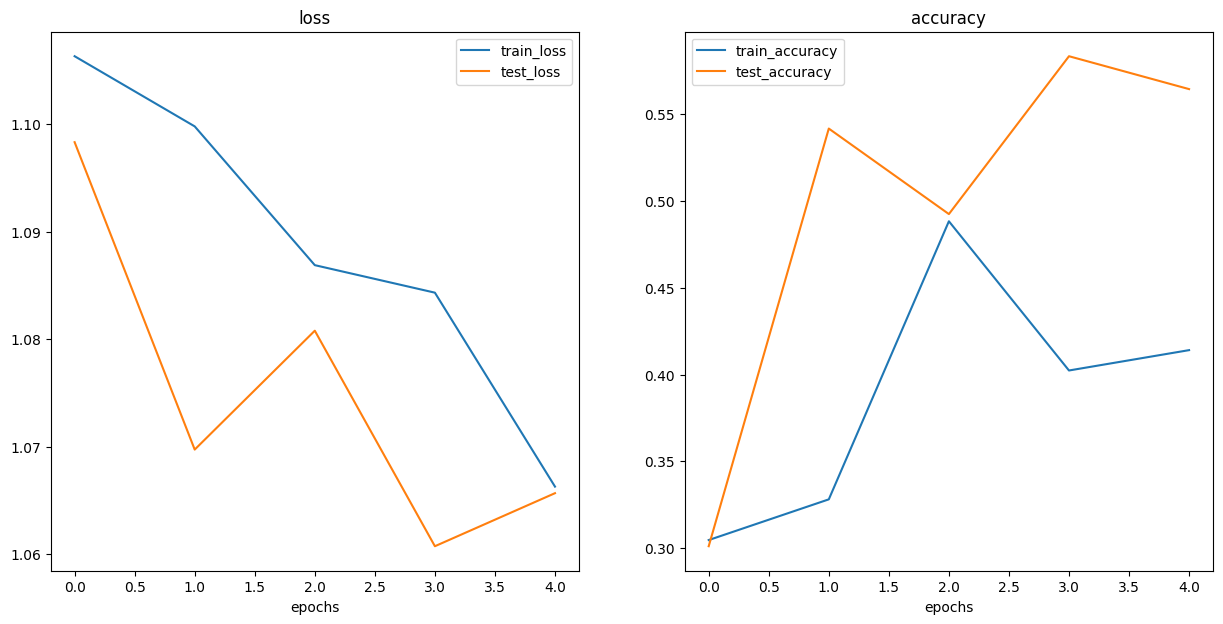

In [62]:
plot_loss_curves(model_0_results)

A loss curve is onr of the most helpful ways to troubleshoot model.

dealing with overfitting:

1.get more data

2.data augmentation

3.better data

4.use transfer learning

5.simplify your model

5.use learning rate decay: decrease your learning rate over time.

6.use early stopping

dealing with underfitting:

1.Add more layers/units to your model

2.tweak the learning rate

3.train for longer

4.use transfer learning

5.use less regularization

model_1: with data augmentation

In [63]:
#create a transform with data augmenattion
train_transform_trivial=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [64]:
#create train and test dataset and dataloaders with data augmentation
train_data_augmented=datasets.ImageFolder(root=train_dir,
                                          transform=train_transform_trivial)


test_data_simple=datasets.ImageFolder(root=test_dir,
                                       transform=test_transform_simple)

In [65]:
import os
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()
torch.manual_seed(42)

train_dataloader_augmented=DataLoader(dataset=train_data_augmented,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      num_workers=NUM_WORKERS)

test_dataloader_simple=DataLoader(dataset=test_data_simple,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   num_workers=NUM_WORKERS)

In [66]:
torch.manual_seed(42)
model_1=TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)
).to(device)

In [67]:
torch.manual_seed(42)
NUM_EPOCHS=5

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(),
                            lr=0.001)

from timeit import default_timer as timer
start_time=timer()
model_1_results=train(
    model=model_1,
    train_dataloader=train_dataloader_augmented,
    test_dataloader=test_dataloader_simple,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS ,
    device=device
)
end_time=timer()
print(f"total training time for model_1:{end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:1 | train_loss:1.1049 | train_acc:0.2500 | test_loss:1.1019 | test_acc:0.2604
Epoch:2 | train_loss:1.0807 | train_acc:0.4258 | test_loss:1.1261 | test_acc:0.2604
Epoch:3 | train_loss:1.0712 | train_acc:0.4258 | test_loss:1.1592 | test_acc:0.2604
Epoch:4 | train_loss:1.1254 | train_acc:0.3047 | test_loss:1.1581 | test_acc:0.2604
Epoch:5 | train_loss:1.0858 | train_acc:0.4258 | test_loss:1.1551 | test_acc:0.3333
total training time for model_1:10.655 seconds


hence,the data augmentation did not help as the model was already underfitting

In [68]:
model_1_results

{'train_loss': [1.1049137264490128,
  1.080678716301918,
  1.071223072707653,
  1.1254291087388992,
  1.0857603549957275],
 'train_acc': [0.25, 0.42578125, 0.42578125, 0.3046875, 0.42578125],
 'test_loss': [1.1019273201624553,
  1.1260881026585896,
  1.15924866994222,
  1.1581004063288372,
  1.1550774574279785],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.3333333333333333]}

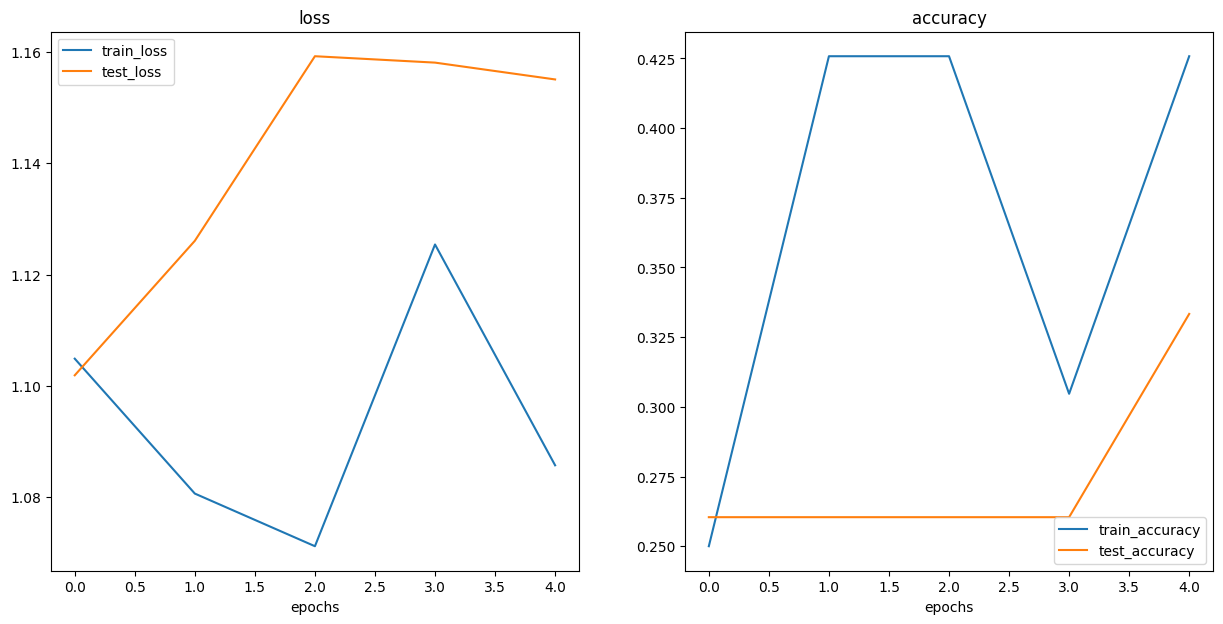

In [69]:
plot_loss_curves(model_1_results)

plotting the loss curves of all of our models against each other

there is few different ways to compare:

1.hard coding

2.pytorch tensorboard

3.weight and biases

4.Mlflow


In [70]:
import pandas as pd
model_0_df=pd.DataFrame(model_0_results)
model_1_df=pd.DataFrame(model_1_results)

model_0_df

train_loss  train_acc  test_loss  test_acc
0    1.106320   0.304688   1.098322  0.301136
1    1.099791   0.328125   1.069718  0.541667
2    1.086879   0.488281   1.080780  0.492424
3    1.084319   0.402344   1.060726  0.583333
4    1.066272   0.414062   1.065661  0.564394

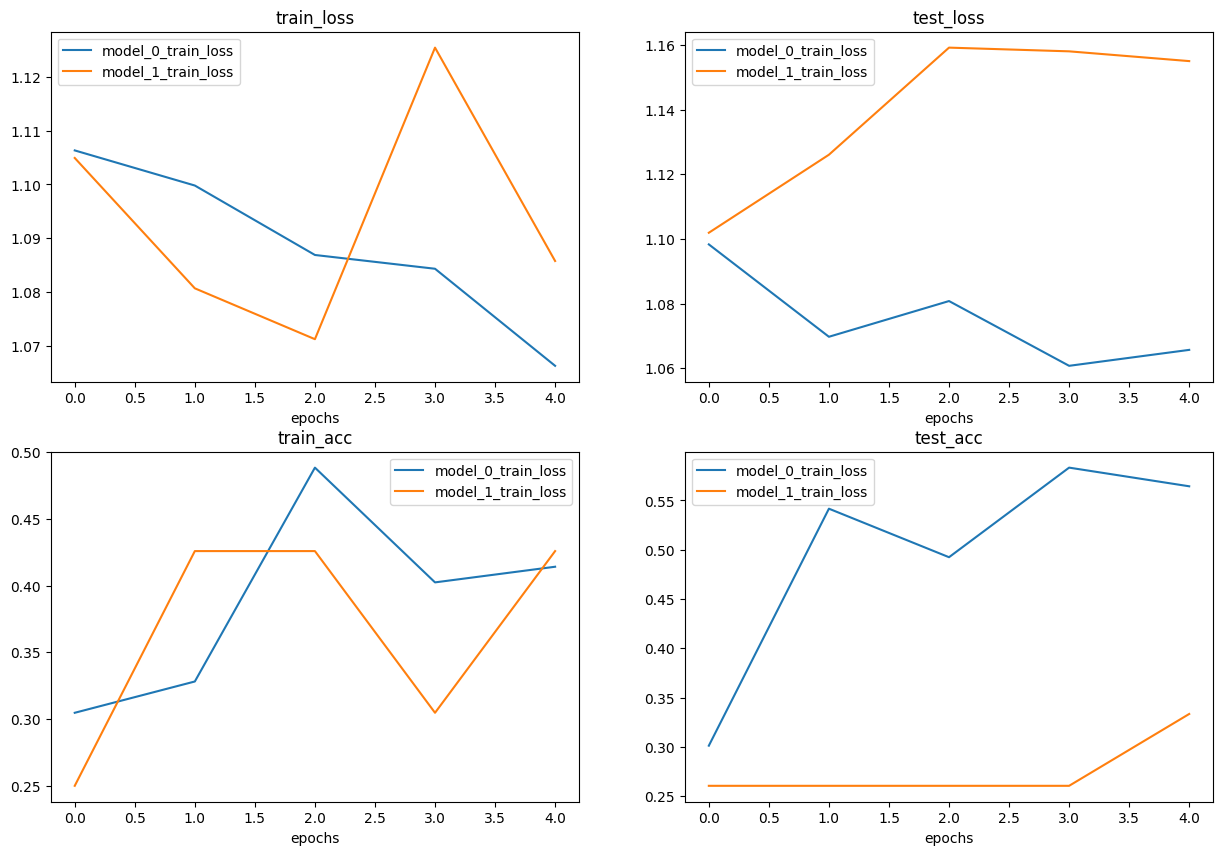

In [71]:
plt.figure(figsize=(15,10))
epochs=range(len(model_0_df))

#plot train loss
plt.subplot(2,2,1)
plt.plot(epochs,model_0_df["train_loss"],label="model_0_train_loss")
plt.plot(epochs,model_1_df["train_loss"],label="model_1_train_loss")
plt.title("train_loss")
plt.xlabel("epochs")
plt.legend()

#plot test loss
plt.subplot(2,2,2)
plt.plot(epochs,model_0_df["test_loss"],label="model_0_train_loss")
plt.plot(epochs,model_1_df["test_loss"],label="model_1_train_loss")
plt.title("test_loss")
plt.xlabel("epochs")
plt.legend()

#plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs,model_0_df["train_acc"],label="model_0_train_loss")
plt.plot(epochs,model_1_df["train_acc"],label="model_1_train_loss")
plt.title("train_acc")
plt.xlabel("epochs")
plt.legend()

#plot train accuracy
plt.subplot(2,2,4)
plt.plot(epochs,model_0_df["test_acc"],label="model_0_train_loss")
plt.plot(epochs,model_1_df["test_acc"],label="model_1_train_loss")
plt.title("test_acc")
plt.xlabel("epochs")
plt.legend()

preicting on a custom data(which is neither in test data nor train data)

In [72]:
#download a custom data

import requests
custom_image_path=data_path/"04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print("downloading...")
    f.write(request.content)
else:
    print("already exits")

downloading...


custom image should be in same format as the data our model was trained on

1.tensor form with datatype torch.float32

2.shape:64x64x3

3.on right device

In [73]:
#read in custom image
import torchvision
custom_image_uint8=torchvision.io.read_image(str(custom_image_path))

custom image shape:torch.Size([3, 4032, 3024])
custom image datatype:torch.uint8


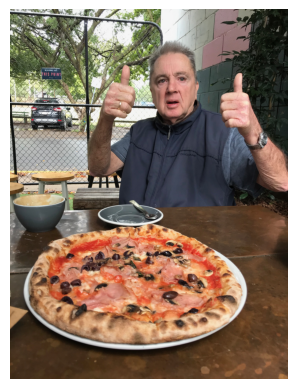

In [74]:
plt.imshow(custom_image_uint8.permute(1,2,0))
plt.axis("off")
print(f"custom image shape:{custom_image_uint8.shape}")
print(f"custom image datatype:{custom_image_uint8.dtype}")
plt.show()

In [75]:
#trying to make prediction on image in uint8 format

#model_1.eval()
#with torch.inference_mode():
  #model_1(custom_image_uint8.to(device))

load in the custom image and convert it to torch.float 32

In [76]:
custom_image=torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255
custom_image.shape,custom_image.dtype
#custom_image

(torch.Size([3, 4032, 3024]), torch.float32)

In [77]:
#model_1.eval()
#with torch.inference_mode():
  #model_1(custom_image.to(device))

In [78]:
#create transform pipeline to resize the image
custom_image_transform=transforms.Compose([
    transforms.Resize(size=(64,64)),
])

#transform target image
custom_image_transformed=custom_image_transform(custom_image)
print(f"original shape:{custom_image.shape}")
print(f"transformed shape:{custom_image_transformed.shape}")

original shape:torch.Size([3, 4032, 3024])
transformed shape:torch.Size([3, 64, 64])


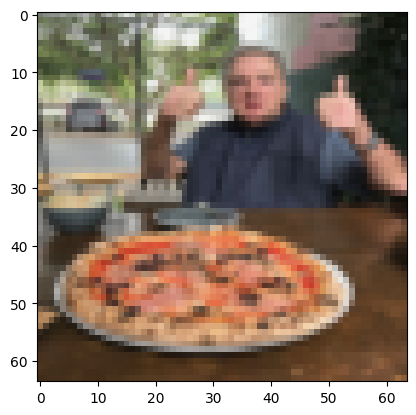

In [79]:
plt.imshow(custom_image_transformed.permute(1,2,0))


In [80]:
#this will error : no batch size
#model_1.eval()
#with torch.inference_mode():
 # custom_image_pred=model_1(custom_image_transformed.to(device))
#custom_image_pred

In [81]:
custom_image_transformed.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [82]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred=model_1(custom_image_transformed.unsqueeze(0).to(device))

In [83]:
custom_image_pred

tensor([[ 0.0797,  0.0359, -0.2083]], device='cuda:0')

In [84]:
class_names

['pizza', 'steak', 'sushi']

logits -> probabilities -> labels

In [85]:
custom_image_pred_probs=torch.softmax(custom_image_pred,dim=1)
custom_image_pred_probs

tensor([[0.3694, 0.3536, 0.2770]], device='cuda:0')

In [86]:
custom_image_pred_label=torch.argmax(custom_image_pred_probs,dim=1).cpu()
custom_image_pred_label

tensor([0])

In [87]:
class_names[custom_image_pred_label]

'pizza'

building a function

A function where we pass an image path to and have our model predict that image and plot the image and predcition

In [90]:
def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names:List[str]=None,
                        transform=None,
                        device=device):

   #load in the image
   target_image=torchvision.io.read_image(str(image_path)).type(torch.float32)

   #divide the image pixel value by 255 to get them between [0,1]
   target_image=target_image/225

   #transform data if necessary
   if transform:
    target_image=transform(target_image)

   #make sure the model is on target device
   model.to(device)

   model.eval()
   with torch.inference_mode():
    target_image=target_image.unsqueeze(0)

    target_image_pred=model(target_image.to(device))
    target_image_pred_probs=torch.softmax(target_image_pred,dim=1)
    target_image_pred_label=torch.argmax(target_image_pred_probs,dim=1)


  #plot the image
   plt.imshow(target_image.squeeze().permute(1,2,0))
   if class_names:
    title=f"pred:{class_names[target_image_pred_label.cpu()]} | Prob:{target_image_pred_probs.max().cpu():.3f}"
   else:
    title=f"pred:{target_image_pred_label} | Prob:{target_image_pred_probs.max().cpu():.3f}"


   plt.title(title)
   plt.axis("off")
   plt.show()


   plt.title(title)
   plt.axis("off")
   plt.show()


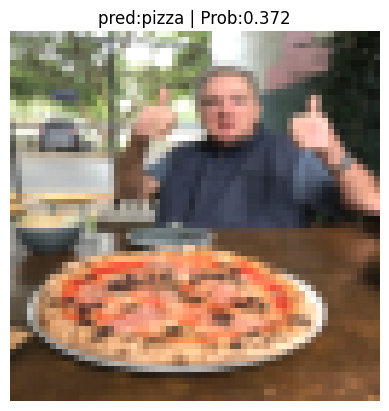

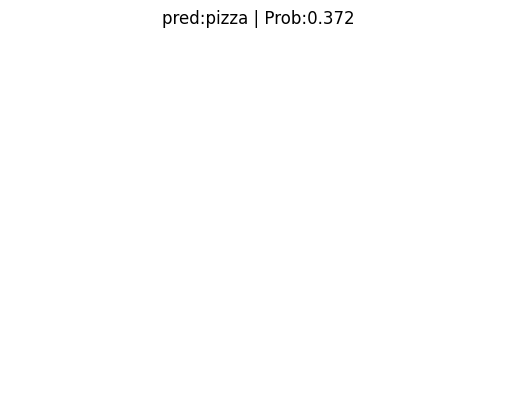

In [92]:
#pred on our custom data

pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)
